In [2]:
import gridworld as gw

In [3]:
env = gw.GridWorld()
action = 0 # ダミーの行動
next_state, reward, done = env.step(action)

print('next_state:', next_state)
print('reward:', reward)
print('done:', done)

next_state: (1, 0)
reward: 0
done: False


In [4]:
env = gw.GridWorld()
state = env.reset()

### エージェントクラスの実装

In [5]:
from collections import defaultdict
import numpy as np

In [6]:
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9 # 割引率
        self.action_size = 4 # 行動の個数

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25} # ランダムな行動を行う確率分布
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0) # 価値関数
        self.cnts = defaultdict(lambda: 0) # 収益の平均を求める際に使用
        self.memory = [] # 状態、行動、報酬というデータ列を保持

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs) # probsの確率分布に従って行動が1つサンプリングされる
    
    # 状態、行動、報酬をまとめる
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    def reset(self):
        self.memory.clear()
    
    def eval(self):
        G = 0
        for data in reversed(self.memory): # 逆向きにたどる
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

### モンテカルロ法を動かす

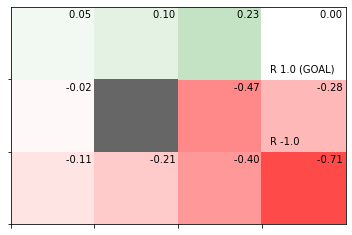

In [8]:
env = gw.GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break
        
        state = next_state
env.render_v(agent.V)

### モンテカルロ法を使った方策制御の実装

In [10]:
class McAgnet:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) # VではなくQを使う
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    def reset(self):
        self.memory.clear()
    
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            self.Q[key] += (G - self.Q[key]) / self.cnts[key] # ②

            self.pi[state] = greedy_probs(self.Q, state)

In [11]:
def greedy_probs(Q, state, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: 0.0 for action in range(action_size)}
    # この時点でaction_probsは{0:0:0, 1:0:0, 2:0:0, 3:0:0}
    action_probs[max_action] = 1 # ①
    return action_probs

#### 修正点
- コードの①：完全なgreedyではなく、ε-greedyにする
- コードの②：Qの更新は「固定値α方式」で行う

### ε-greedy法（1つ目の修正）

In [12]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    # この時点でaction_probsは{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

### 固定値α方式へ（2つ目の修正）

In [13]:
class McAgnet:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) # VではなくQを使う
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    def reset(self):
        self.memory.clear()
    
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            # 修正前
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key] # ②

            # 修正後
            alpha = 0.1
            self.Q[key] += (g - self.Q[key]) * alpha # ②

            self.pi[state] = greedy_probs(self.Q, state)

### [修正版]モンテカルロ法を使った方策反復法の実装

In [16]:
class McAgnet:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1 # ε-greedyのε
        self.alpha = 0.1 # Q値を更新する際の固定値alpha
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) # VではなくQを使う
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    def reset(self):
        self.memory.clear()
    
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha # ①
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

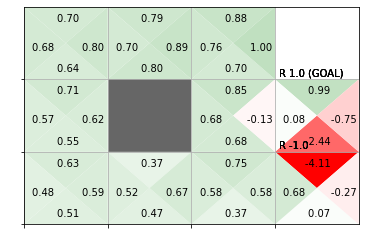

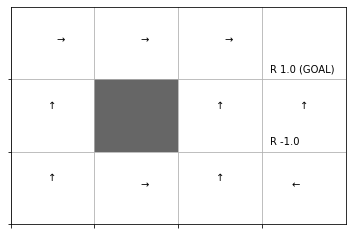

In [17]:
env = gw.GridWorld()
agent = McAgnet()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state
env.render_q(agent.Q)

### 重点サンプリング
- ある確率分布の期待値を、別の確率分布からサンプリングしたデータを使って計算する手法

In [18]:
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# 期待値
e = np.sum(x * pi)
print('E_pi[x]', e)

# モンテカルロ法
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print('MC:{:.2f} (var: {:.2f})'.format(mean, var))

E_pi[x] 2.7
MC:2.76 (var: 0.34)


In [20]:
b = np.array([1/3, 1/3, 1/3])
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b)) # [0, 1, 2]
    i = np.random.choice(idx, p=b) # bを使ってサンプリング
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 2.67 (var: 10.11)


In [21]:
b = np.array([0.2, 0.2, 0.6]) # 確率分布を変更
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b)) # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 3.03 (var: 2.21)
